# 2025-11-17 ODE Exercise

We will implement a ODE simulation of a [simple gravity pendulum](https://en.wikipedia.org/wiki/Pendulum_(mechanics)#Simple_gravity_pendulum).
At various points in this exercise, you will have the ability to modify the code to explore different variations on the project.

## The math

Let us consider a weight at the end of a massless arm attached to a frictionless pivot.
We will only consider motion in two dimensions for this example.

The differential equation which governs the motion of this pendulum is given by

$$ \frac{d^2 \theta}{d t^2} + \frac{g}{l} \sin \left( \theta \right) = 0 $$

where $g$ is the [gravitational constant](https://en.wikipedia.org/wiki/Gravity_of_Earth), $l$ is the length of the arm, and $\theta$ is the angle from vertical for the pendulum.

Note: Wikipedia has a nice pair of derivations for this equation.
It is a good example of deriving the equation for our simulation from [first principles](https://en.wikipedia.org/wiki/First_principle) (in this case, physical laws around force, torque, or energy).

### Extension

Note that we can change the constants $g$ and $l$ here to modify our simulation.
We could also change our differential equation to represent more complex behavior.

### A complication

The time steppers for ODEs we saw in class only support first derivatives with respect to time, not second derivatives.
There is a common trick we can employ though.

Let $v = \frac{d \theta}{d t}$ and note that $\frac{d v}{d t} = \frac{d^2 \theta}{d t^2}$.
Then

$$ \begin{split}
  \frac{d \theta}{d t} &= v\\
  \frac{d v}{d t}      &= - \frac{g}{l} \sin \left( \theta \right)
\end{split} $$

We now have a system of first order equations and can use our techniques from class.

In [1]:
# Some simulation constants
# Note that we can change these
g = 9.81 # m/s^2
l = 10   # m

# Function to represent our physics
function dFdt(x)
    θ = x[1]
    v = x[2]
    return [v; (-g/l)*sin(θ)]
end

dFdt (generic function with 1 method)

## Initial conditions

We needed initial conditions for our timesteppers in class.
Here, we will need initial values for $\theta$ and $v$, so an initial displacement and initial velocity.

In [2]:
# Initial conditions
θ_0 = π/4 # 45°
v_0 = -1  # m/s
x_0 = [θ_0; v_0]

2-element Vector{Float64}:
  0.7853981633974483
 -1.0

## Visualize

It would be really nice if we can visualize out results.
We could plot $\theta$ as a function of $t$, but that wouldn't make a nice graphic of a swinging pendulum.
To make a graphic of a swinging pendulum, we need the coordinates $\left( x, y \right)$ of our pendulum.

We should pick a coordinate system first.
Then we would indicate where $\theta$ is relative to our coordinate system and derive the coordinates of the weight from this diagram.

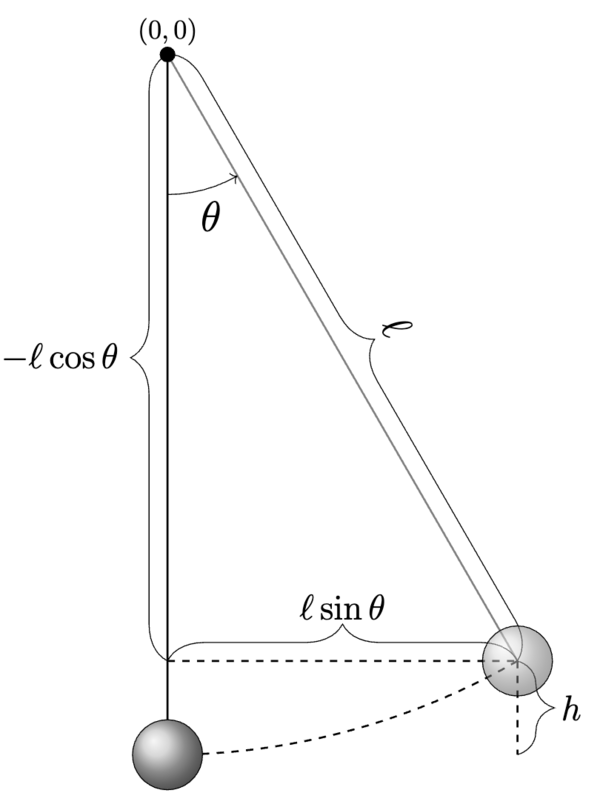

Given this diagram, we can now say that

$$ x = l \sin \left( \theta \right), y = - l \cos \left( \theta \right) $$

With this, we can plot the initial location of our pendulum.

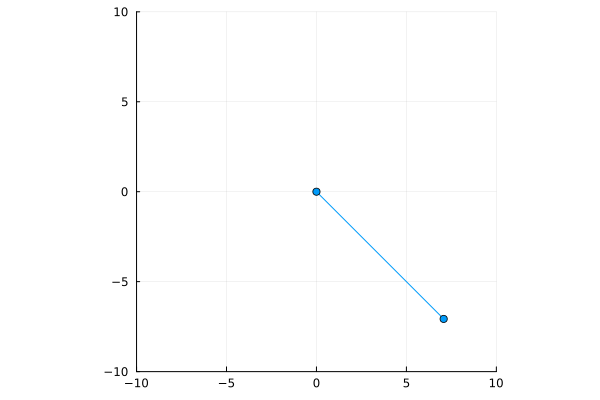

In [3]:
using Plots

x =  l * sin(θ_0)
y = -l * cos(θ_0)
plot([(0, 0), (x, y)],
    xlims=[-l, l], ylims=[-l, l],
    marker=:circle,
    legend=:none, aspect_ratio=:equal)

## Time Stepper

Now we need to pick one of our for advancing our solution forward in time.
This is the area where we can experiment the most.
For now, let's use a simple [forward Euler](https://en.wikipedia.org/wiki/Euler_method).

$$ x_{n + 1} = x_n + h \, dF \left( t_n, x_n \right) $$

where $t_n$ is the current time, $x_n$ is the current solution, $h$ is our step size in time, $dF$ is our differential equation, and $x_{n + 1}$ is our new solution.

Let's code up forward Euler and take a single step.

x_1 = euler_forward(x_0, h, dFdt) = [0.6853981633974483, -1.0693671752344003]


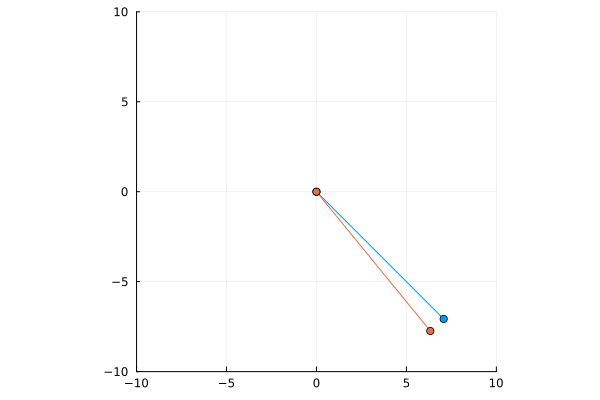

In [4]:
# Forward euler
function euler_forward(x, h, dF)
    return x + h * dF(x)
end

# And take a single step
h  = 1e-1
@show x_1 = euler_forward(x_0, h, dFdt)

# And plot
x =  l * sin(θ_0)
y = -l * cos(θ_0)
plot([(0, 0), (x, y)],
    xlims=[-l, l], ylims=[-l, l],
    marker=:circle,
    legend=:none, aspect_ratio=:equal)

θ_1 = x_1[1]
x =  l * sin(θ_1)
y = -l * cos(θ_1)
plot!([(0, 0), (x, y)], marker=:circle)

We can also do this with backward Euler.

x_1 = euler_backward(x_0, h, dFdt) = [0.6792355369698221, -1.061626264511185]


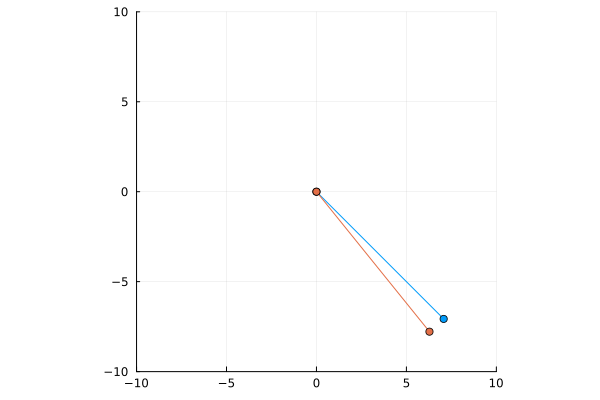

In [5]:
using LinearAlgebra

# Backward euler
function euler_backward(x, h, dF)
    # Fixed point iteration
    x_n1 = x + h * dF(x)
    x_n2 = x + h * dF(x_n1)
    # Note - this is a simple fixed point iteration - could we do this better?
    tol = 1e-10
    while (norm(x_n1 - x_n2) > tol)
        x_n1 = x_n2
        x_n2 = x + h * dF(x_n1)
    end
    return x_n1
end

# And take a single step
h  = 1e-1
@show x_1 = euler_backward(x_0, h, dFdt)

# And plot
x =  l * sin(θ_0)
y = -l * cos(θ_0)
plot([(0, 0), (x, y)],
    xlims=[-l, l], ylims=[-l, l],
    marker=:circle,
    legend=:none, aspect_ratio=:equal)

θ_1 = x_1[1]
x =  l * sin(θ_1)
y = -l * cos(θ_1)
plot!([(0, 0), (x, y)], marker=:circle)

### Exploration

Implement the $\theta$ method.

## Building it out

Ok, now it seems like we need two things right now.

1) Something to take our time stepper (`euler_forward`) and our function (`dFdt`) and create a series of outputs.

2) Something to automate and animate the plotting process.

Let's start with 1).
We'll make a basic function `run_simulation` to produce our values $\theta$ and $v$ via our ODE and time stepper.

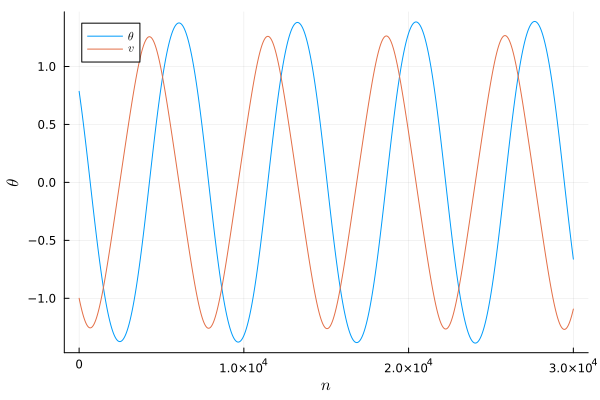

In [6]:
function run_simulation(x_0, h, dF, time_stepper, t_f)
    # Setup
    num_steps = Int(ceil(t_f / h))
    x = zeros((num_steps + 1, maximum(size(x_0))))
    x[1, :] = x_0

    # Simulate
    for i in 1:num_steps
        x[i + 1, :] = time_stepper(x[i, :], h, dF)
    end
    x
end

# And run it
h   = 1e-3
t_f = 30 # s
x  = run_simulation(x_0, h, dFdt, euler_forward, t_f)

# Plotting the θ and v as a sanity check
plot([x[:, 1], x[:, 2]], xlabel="\$n\$", ylabel="\$\\theta\$", label=["\$\\theta\$" "\$v\$"])

Take a look at our plots of $\theta$ and $v = d \theta / d t$.

Is anything concerning to you?

What happens if we use backward Euler instead?

What about a $\theta$ method instead?

## Pretty pictures

The plotting isn't too bad once we have the solution array.

In [7]:
# We wrap the plotting in an annotated loop
animation = @animate for i in 1:maximum(size(x))
    θ_n = x[i, 1]
    x_n =  l * sin(θ_n)
    y_n = -l * cos(θ_n)
    plot([(0, 0), (x_n, y_n)],
        xlims=[-l, l], ylims=[-l, l],
        marker=:circle,
        legend=:none, aspect_ratio=:equal)
end every 100;

[ Info: Saved animation to /home/jovyan/CSCI3656/exploration/pedulum.gif


Plots.AnimatedGif("/home/jovyan/CSCI3656/exploration/pedulum.gif")
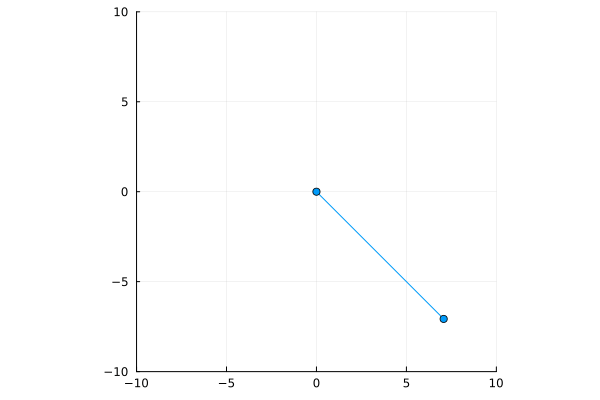

In [8]:
gif(animation, "pedulum.gif", fps=30)

# Exploration

### Class notes
When v is increase too high, the simulation only going in one direction

We could add physics to simulate real world

satellite orbit equations - replace df and plotting functions to replicate orbits

can mess with initial velocity, initial angle, gravity, etc. 

Replace forward euler with backward euler. Make it better and able to be done in less timesteps.. compute some fixed point iteration.

### Variable exploration

Overall, when changing some of the constants like g, l and the intial conditions, you usually get the expected behavior from these functions. There a few unique values that output interesting behavior, but I found it more interesting to explore the implementation of a double pendulum below.

## Double Pendulum

In [48]:
# Some simulation constants
# Note that we can change these
g = 9.81 # m/s^2
l = 10   # m
m = 10

# Function to represent our physics
function dFdt(x)
    θ1 = x[1]
    v1 = x[2]
    θ2 = x[3]
    v2 = x[4]
    c, s = cos(θ1-θ2), sin(θ1-θ2)
    
    v1dot = (m * g * sin(θ2) * c - m * s * (l * v1^2 * c + l * v2^2) -
             2m * g * sin(θ1)) / l / (m + m * s^2)

    v2dot = ((2m) * (l * v1^2 * s - g * sin(θ2) + g * sin(θ1) * c) + 
            m * l * v2^2 * s * c) / l / (m + m * s^2)
    
    return [v1; v1dot; v2; v2dot]
end
θ1_0 = π/4
v1_0 = -1
θ2_0 = π/4
v2_0 = -1
x_0 = [θ1_0, v1_0, θ2_0, v2_0]

4-element Vector{Float64}:
  0.7853981633974483
 -1.0
  0.7853981633974483
 -1.0

In [49]:
h   = 1e-3
t_f = 30 # s
x  = run_simulation(x_0, h, dFdt, euler_forward, t_f)

30001×4 Matrix{Float64}:
  0.785398  -1.0         0.785398  -1.0
  0.784398  -1.00069     0.784398  -1.0
  0.783397  -1.00139     0.783398  -1.0
  0.782396  -1.00208     0.782398  -1.0
  0.781394  -1.00277     0.781398  -1.0
  0.780391  -1.00346     0.780398  -1.0
  0.779388  -1.00415     0.779398  -1.0
  0.778384  -1.00484     0.778398  -1.0
  0.777379  -1.00553     0.777398  -1.0
  0.776373  -1.00622     0.776398  -1.0
  0.775367  -1.00691     0.775398  -1.0
  0.77436   -1.00759     0.774398  -1.0
  0.773353  -1.00828     0.773398  -1.0
  ⋮                                
 -2.04429   -0.577248  -12.8097     0.511509
 -2.04487   -0.576231  -12.8092     0.511653
 -2.04545   -0.575215  -12.8087     0.511798
 -2.04602   -0.574198  -12.8082     0.511946
 -2.0466    -0.57318   -12.8077     0.512095
 -2.04717   -0.572163  -12.8072     0.512247
 -2.04774   -0.571146  -12.8066     0.5124
 -2.04831   -0.570129  -12.8061     0.512554
 -2.04888   -0.569111  -12.8056     0.512711
 -2.04945   -0.5

In [50]:
# We wrap the plotting in an annotated loop
animation = @animate for i in 1:size(x, 1)
    θ1 = x[i, 1]
    θ2 = x[i, 3]
    x1 =  l * sin(θ1)
    y1 = -l * cos(θ1)
    x2 = x1 + l * sin(θ2)
    y2 = y1 - l * cos(θ2)

    plot([0, x1, x2], [0, y1, y2],
        xlims = [-2l, 2l], ylims = [-2l, 2l],
        marker = :circle,
        legend = false, aspect_ratio = :equal)
end every 100;

[ Info: Saved animation to /home/jovyan/CSCI3656/exploration/double_pedulum.gif


Plots.AnimatedGif("/home/jovyan/CSCI3656/exploration/double_pedulum.gif")
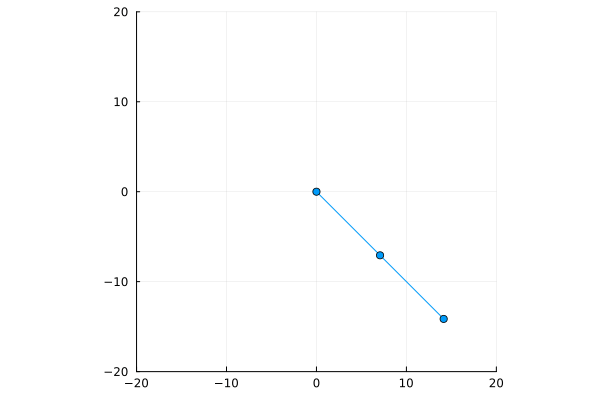

In [51]:
gif(animation, "double_pedulum.gif", fps=30)

### References:
- https://en.wikipedia.org/wiki/Double_pendulum
- https://scipython.com/blog/the-double-pendulum/
- https://matplotlib.org/stable/gallery/animation/double_pendulum.html